In [1]:
# Google Colab으로 수행한다면 이 셀을 먼저 실행해주세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install lightgbm
    !pip install shap
    !pip install PDPbox

# DATA SCIENCE / SECTION 2 / PROJECT

**주제** 

 <> 독일 브랜드 자동차 가격 예측

 **분석내용**

<> 모델링을 통한 원하는 종류의 차량의 가격 예측

# 1. 사용 데이터 생성

In [1]:
import pandas as pd

data =  pd.read_csv('/content/drive/MyDrive/data/Project2/project2_dataset.csv')


# 2. 전처리 및 EDA



*   생성 데이터 확인




In [2]:
data.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011




*   데이터 정보 확인




In [3]:
data.shape, data.columns

((46405, 9),
 Index(['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'price', 'hp',
        'year'],
       dtype='object'))

In [4]:
#결측치 확인
data.isnull().sum()

mileage        0
make           0
model        143
fuel           0
gear         182
offerType      0
price          0
hp            29
year           0
dtype: int64

In [5]:
#결측치가 여러부분 존재하지만 전체 데이터의 수에 비해 현저히 적으므로 삭제
#다른것으로 대체하기에는 알 수 없는 부분이 많음
data = data.dropna()

In [6]:
#중복값 확인
data.duplicated().sum()

2124

In [7]:
#중복값 제거
data = data.drop_duplicates(keep='first')
data.shape

(43947, 9)

In [8]:
pd.set_option('display.float_format', '{:.2f}'.format) # float 형식으로 
data.describe()
#pd.set_option('display.float_format', None) # 원상복구


,mileage,price,hp,year
count,43947.00,43947.00,43947.00,43947.00
mean,72312.58,16546.56,133.62,2015.93
std,62173.36,19446.80,75.05,3.12
min,0.00,1100.00,1.00,2011.00
25%,21500.00,7490.00,86.00,2013.00
50%,61309.00,10990.00,116.00,2016.00
75%,106000.00,19490.00,150.00,2019.00
max,1111111.00,1199900.00,850.00,2021.00


새로운 항목 생성

In [9]:
#연식만 나와있으므로 현재의 연도에서 'year'항목을 빼서 새로운 항목생성
from datetime import datetime
#새로운 항목생성
data['years'] = datetime.now().year - data['year']

#기존 연식항목은 삭제
data.drop('year', axis=1, inplace=True)

data.head()

,mileage,make,model,fuel,gear,offerType,price,hp,years
0,235000,BMW,316,Diesel,Manual,Used,6800,116.00,10
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.00,10
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.00,10
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.00,10
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.00,10


# 3. 데이터 확인

* 타겟(price)과의 상관계수



In [10]:
corr_df = data.corr()

corr_df['price'].sort_values(ascending=False)

price      1.00
hp         0.75
mileage   -0.31
years     -0.41
Name: price, dtype: float64

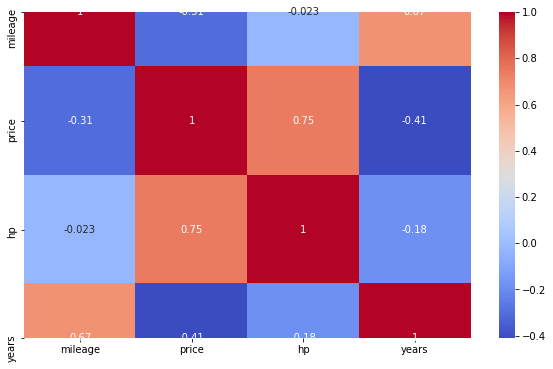

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(data.corr(),annot=True, cmap='coolwarm')

예측한 가격이 $16,547,
평균 절대 오차는 $10,339


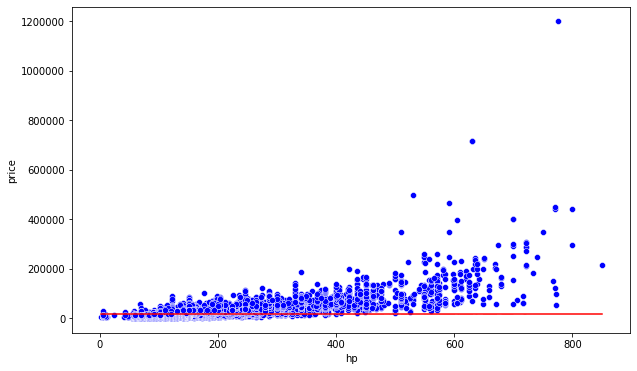

In [152]:
x = data['hp']
y = data['price']

predict = data['price'].mean()
errors = predict - data['price']
mean_absolute_error = errors.abs().mean()

plt.figure(figsize=(10,6))
sns.lineplot(x=x, y=predict, color='r')
sns.scatterplot(x=x, y=y, color='b')
print(f'예측한 가격이 ${predict:,.0f},\n평균 절대 오차는 ${mean_absolute_error:,.0f}')


 *   Outlier 확인 및 제거




분위수 상위1%와 하위1% 제외


*   Price Outlier


In [13]:
min, max = data.price.quantile([0.01, 0.99])
min, max

(3300.0, 83468.84000000004)

In [14]:
#Outlier 상위1%와 하위1% 갯수
data[data['price']>max].value_counts().sum(), data[data['price']<min].value_counts().sum()

(440, 435)

In [15]:
#Outlier 제거
data_car = data[(data.price<max) & (data.price>min)]
data_car.shape

(43044, 9)

예측한 가격이 $15,440,
평균 절대 오차는 $8,742


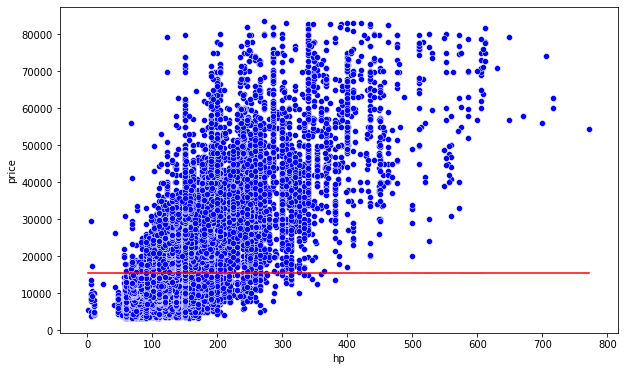

In [153]:
x1 = data_car['hp']
y1 = data_car['price']

predict1 = data_car['price'].mean()
errors1 = predict1 - data_car['price']
mean_absolute_error1 = errors1.abs().mean()

plt.figure(figsize=(10,6))
sns.lineplot(x=x1, y=predict1, color='r')
sns.scatterplot(x=x1, y=y1, color='b')
print(f'예측한 가격이 ${predict1:,.0f},\n평균 절대 오차는 ${mean_absolute_error1:,.0f}')

Outlier 제거 후 평균가격은 상승하였지만 MAE가 제거 전 보다 좋아짐을 알 수 있다.




*   target의 중앙값, 평균값 및 최빈값 확인




In [17]:
#중앙값
median = data_car['price'].median()
#평균값
mean = data_car['price'].mean()
#최빈값
mode = data_car['price'].mode()

print(f'중앙값 : {median:.0f}')
print(f'평균값 : {mean:.0f}')
print('최빈값 :', mode[0])

중앙값 : 10990
평균값 : 15440
최빈값 : 7990


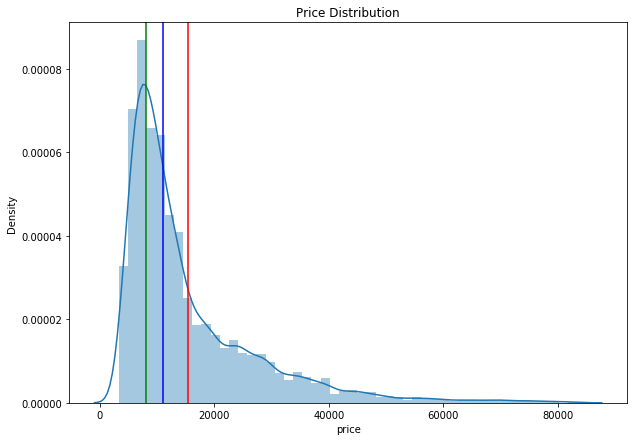

In [156]:
plt.figure(figsize=(10,7))
sns.distplot(data_car['price'], kde=True).set_title('Price Distribution')
# plt.hist(x='price',data=data_car)
# plt.title('Price count')
# plt.xlabel('price')
# plt.ylabel('count')

plt.axvline(median, color='b')
plt.axvline(mean, color='r')
plt.axvline(mode[0], color='g')



# 4. Modeling







*   카테고리 특성의 카디널리티 리스트



In [19]:
selected_cols = data.select_dtypes(include=['object'])
labels = selected_cols.nunique() 
labels.sort_values(ascending=False)

model        835
make          71
fuel          11
offerType      5
gear           3
dtype: int64



*   카디널리티가 높은 특성 삭제



In [20]:
#모델명과 제조사 삭제
data_car = data_car.drop(columns=['make', 'model'], axis=1)


In [21]:
#비슷한 종류의 연료끼리 묶음
data_car['fuel'] = data_car['fuel'].replace(('Electric/Gasoline', 'Electric/Diesel', 'Electric'), 'Electric')
data_car['fuel'] = data_car['fuel'].replace(('CNG', 'LPG', 'Others', '-/- (Fuel)', 'Ethanol', 'Hydrogen'), 'Others')

In [22]:
data_car['fuel'].unique()

array(['Diesel', 'Gasoline', 'Electric', 'Others'], dtype=object)

In [23]:
data_car.dtypes.value_counts()

object     3
int64      3
float64    1
dtype: int64

In [24]:
#데이터 분리
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_car, test_size = 0.3, random_state = 2)
train.shape, test.shape

((30130, 7), (12914, 7))

In [25]:
target = 'price'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]




*   Ridge Regression



In [26]:
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

pipe1 = make_pipeline(
      TargetEncoder()
    , SimpleImputer()
    , StandardScaler()
    , SelectKBest(f_regression)
    , Ridge()
)

dists1 = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1, 10], 
}

clf1 = RandomizedSearchCV(
    pipe1, 
    param_distributions=dists1, 
    n_iter=50, 
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [27]:
clf1.fit(X_train, y_train);

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    8.5s finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [28]:
pipe1 = clf1.best_estimator_

In [29]:
from sklearn.metrics import accuracy_score

print('최적 하이퍼파라미터: ', clf1.best_params_)
print('MAE: ', -clf1.best_score_)
print('학습Ridge 정확도   : ', pipe1.score(X_train, y_train))
print('테스트Ridge 정확도 : ', pipe1.score(X_test, y_test))


최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 6, 'ridge__alpha': 10}
MAE:  3246.2158846369052
학습Ridge 정확도   :  0.8250400243158913
테스트Ridge 정확도 :  0.8263654931143147




*   Ridge Regression Coefficient



In [30]:
# 회귀계수
coefficients = pipe1.named_steps['ridge'].coef_
pd.Series(coefficients, features)

mileage     -2613.85
fuel          838.27
gear         1294.48
offerType     910.39
hp           7744.80
years       -3131.08
dtype: float64

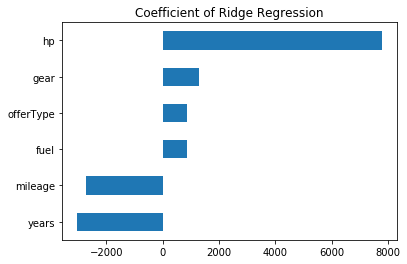

In [41]:
model_rg = pipe1.named_steps['ridge']
coefficients = pd.Series(model_rg.coef_, features)
coefficients.sort_values().plot.barh();
plt.title('Coefficient of Ridge Regression')
plt.show()

mileage가 1마일이 증가할수록 2613씩 price가 감소

years가 1년씩 증가할수록 3131씩 price가 감소

hp가 1씩 증가할수록 7744씩 price가 증가



*   Linear Regression





In [31]:
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    LinearRegression()
)

dists = {
    'simpleimputer__strategy' : ['median', 'mean']
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)


In [32]:
clf.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [33]:
pipe = clf.best_estimator_

In [34]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)
print('학습 Linear 정확도   : ', pipe.score(X_train, y_train))
print('테스트 Linear 정확도 : ', pipe.score(X_test, y_test))

최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median'}
MAE:  3246.6208429515386
학습 Linear 정확도   :  0.8250400891415657
테스트 Linear 정확도 :  0.826369404791421



*   XGB Regressor
*   Permutation Importance



In [36]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe2 = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(), SimpleImputer())),
    ('xgb', XGBRegressor(n_estimators=100, random_state=2, n_jobs=-1)) 
])

In [37]:
# pipeline 생성을 확인합니다.
pipe2.named_steps

{'preprocessing': Pipeline(memory=None,
          steps=[('targetencoder',
                  TargetEncoder(cols=None, drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                min_samples_leaf=1, return_df=True,
                                smoothing=1.0, verbose=0)),
                 ('simpleimputer',
                  SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                missing_values=nan, strategy='mean',
                                verbose=0))],
          verbose=False),
 'xgb': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              importance_type='gain', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='reg:linear', random_state=2,
              reg_alpha

In [38]:
pipe2.fit(X_train, y_train)
print('테스트 XGB 정확도: ', pipe.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[01:16:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
테스트 XGB 정확도:  0.826369404791421


In [39]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe2.named_steps['xgb'], # model
    scoring='r2', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_test_transformed = pipe2.named_steps['preprocessing'].transform(X_test)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_test_transformed, y_test);

In [40]:
# 특성별 score 확인
feature_names = X_test.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.7880 ± 0.0143,hp
0.2560 ± 0.0062,years
0.0943 ± 0.0050,mileage
0.0339 ± 0.0024,fuel
0.0265 ± 0.0025,gear
0.0024 ± 0.0004,offerType


In [41]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_test_encoded = encoder.transform(X_test) # 검증데이터

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:16022.2	validation_1-rmse:16162.9
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:13279.6	validation_1-rmse:13399.8
[2]	validation_0-rmse:11133.9	validation_1-rmse:11250.2
[3]	validation_0-rmse:9476.56	validation_1-rmse:9553.83
[4]	validation_0-rmse:8174.77	validation_1-rmse:8225.56
[5]	validation_0-rmse:7166.51	validation_1-rmse:7213.32
[6]	validation_0-rmse:6421.99	validation_1-rmse:6452.41
[7]	validation_0-rmse:5864.95	validation_1-rmse:5883.07
[8]	validation_0-rmse:5440.52	validation_1-rmse:5457.01
[9]	validation_0-rmse:5120.23	validation_1-rmse:5138.74
[10]	validation_0-rmse:4874.18	validation_1-rmse:4898.61
[11]	validation_0-rmse:4708.8	validation_1-rmse:4736.74
[12]	validation_0-rmse:4570.52	validation_1-rmse:4605.85
[13]	validation_0-rmse:4460.36	validation_1-rmse:4500.88
[14]	validation_0-rmse:4384.39	validation_1-rmse:4423.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [42]:
y_pred = boosting.predict(X_test_encoded)
print('R^2              :' , r2_score(y_test, y_pred))
print('테스트 XGB 정확도:', boosting.score(X_test_encoded, y_test))


R^2              : 0.9082139433347136
테스트 XGB 정확도: 0.9082139433347136


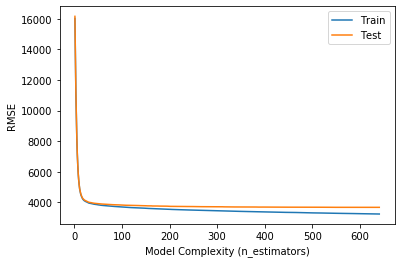

In [43]:
results = boosting.evals_result()
train_error = results['validation_0']['rmse']
test_error = results['validation_1']['rmse']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label = 'Train')
plt.plot(epoch, test_error, label = 'Test')
plt.ylabel('RMSE')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

*  그래디언트 부스팅 모델 

PDP isolation

In [44]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature1 = 'hp'
feature2 = 'years'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


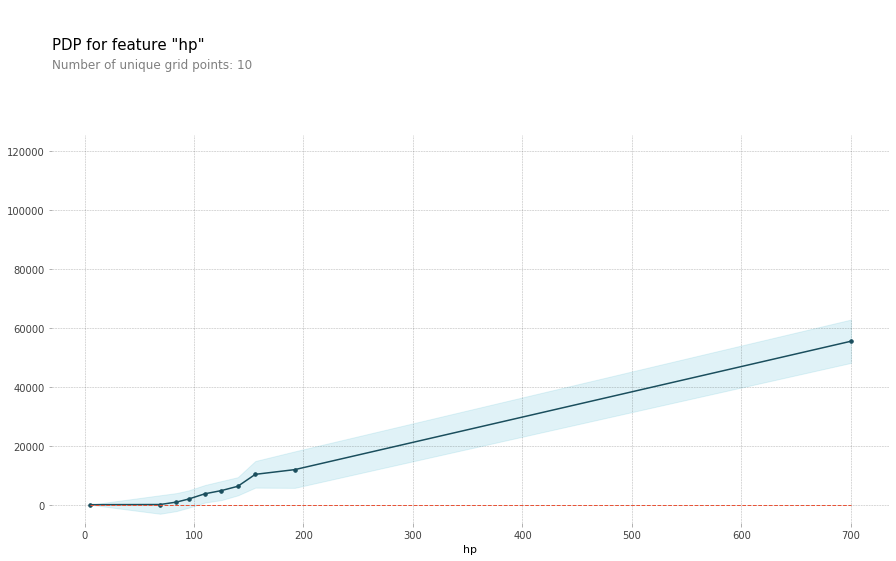

In [45]:
#그래디언트 부스팅 모델 각 특성의 PDP
isolated = pdp_isolate(
    model=boosting, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature1
)
pdp_plot(isolated, feature_name=feature1);

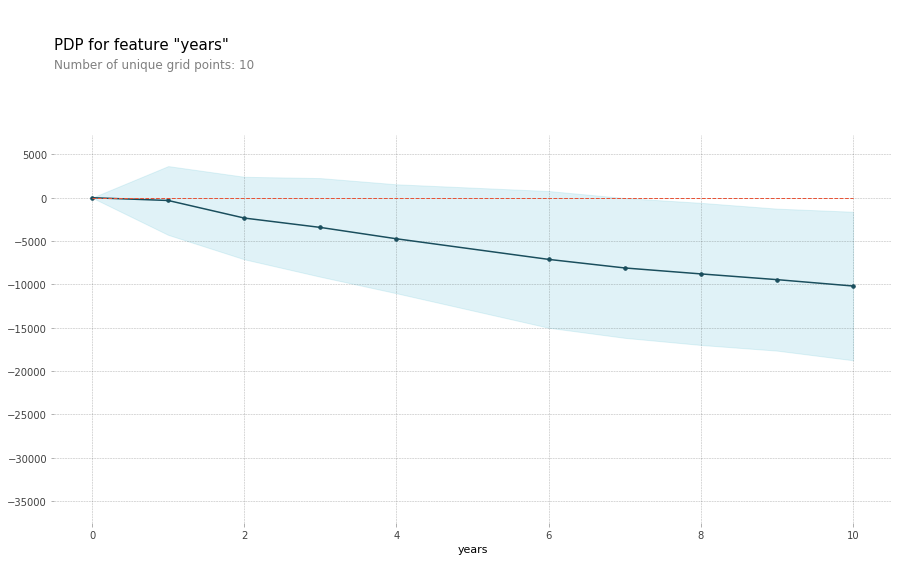

In [46]:
isolated = pdp_isolate(
    model=boosting, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature2
)
pdp_plot(isolated, feature_name=feature2);



*   RandomForest Regressor


In [131]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=2), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2
)



In [132]:
search.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [140]:
print('최적 하이퍼파라미터: ', search.best_params_)
print('CV MAE  :', -search.best_score_)

y_pred_ts = model.predict(X_test_encoded)
print('R^2     :', r2_score(y_test, y_pred_ts))

model = search.best_estimator_

최적 하이퍼파라미터:  {'max_depth': 15, 'max_features': 0.6327377306009369, 'n_estimators': 166}
CV MAE  : 2257.311922282542
R^2     : 0.9058299729796003


# 5. 원하는 사양의 가격 예측

In [144]:
def predict(mileage, fuel, gear, offerType, hp, years):

    # 함수 내에서 예측에 사용될 input을 만듭니다
    data_car = pd.DataFrame(
        data=[[mileage, fuel, gear, offerType, hp, years]], 
        columns=['mileage', 'fuel', 'gear', 'offerType', 'hp', 'years']
    )

    # 예측
    pred = model.predict(data_car)[0]

    # Shap value를 계산합니다
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(row)

    # Shap value, 특성이름, 특성값을 가지는 Series를 만듭니다
    feature_names = data_car.columns
    feature_values = data_car.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # 결과를 프린트 합니다.
    result = f'평균가격: ${explainer.expected_value[0]:,.0f} \n'
    result += f'예측가격: ${pred:,.0f} \n'
    result += shaps.to_string()
    print(result)


    # SHAP Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=data_car
    )

In [142]:
data_car['fuel'].unique()

array(['Diesel', 'Gasoline', 'Electric', 'Others'], dtype=object)

In [112]:
data_car['gear'].unique()

array(['Manual', 'Automatic', 'Semi-automatic'], dtype=object)

In [113]:
data_car['offerType'].unique()

array(['Used', 'Demonstration', "Employee's car", 'Pre-registered', 'New'],
      dtype=object)

In [145]:
#predict((mileage, fuel, gear, offerType, hp, years)
#첫번째 원하는 차량은 0마일, 전기차, 자동, 신차, 400마력, 신차이므로 연식없음  
predict(0,3,2,5,400,0)

평균가격: $15,419 
예측가격: $68,438 
(mileage, 0)     -4107.52
(fuel, 3)          988.01
(gear, 2)         2943.96
(offerType, 5)    -182.95
(hp, 400)        10739.66
(years, 0)        1354.92


In [151]:
#두번째 원하는 차량은 1000마일과 연식1년의 중고차고 나머지 조건은 동일
predict(1000,3,2,1,400,1)

평균가격: $15,419 
예측가격: $61,476 
(mileage, 1000)   -4107.52
(fuel, 3)           988.01
(gear, 2)          2943.96
(offerType, 1)     -182.95
(hp, 400)         10739.66
(years, 1)         1354.92


# 6.결과 및 한계






결과
*   완전한 신차도 좋지만 금액적인 부분에서 짧은 연식의 중고차를 구매하는것도 좋은 선택이 될 것 같다.

한계
*   하지만 연식은 lower 쪽에 있어야 한다고 생각되는데 higher쪽에 있는 것을보면

 모델링 실력과 이해도가 낮아 정확한 예측이 되지 않은것 같다.



*   또한 정확한 모델링과 이해도가 높다고 하더라도 실제 차량구매에 필요한 사고이력등의 중요한 내용이 빠져있으므로

 본 자료로의 정확한 예측에는 한계가 있어보인다.






